### Extract Retinal Features in Parallel

With pip install:

1. Install pywavelets
2. Install imutils
3. Install mahotas

From “refactoring”:
python setup.py install -f

In [1]:
from IPython.parallel import Client
c = Client()

In [13]:
%%px --local
import numpy as np
import pandas as pd
from kobra.dr import Labels
from kobra import TrainFiles
from kobra.tr_utils import prep_out_path, time_now_str
import os
from os import path
import mahotas as mh
import mahotas.labeled as mhl
import cv2
import time
import matplotlib.pylab as plt
import shutil
preprocessed = '/home/boris/Kaggle/train/prep'
masks = '/home/boris/Kaggle/train/prepmasks'
orig = '/home/boris/Kaggle/Retina/train/raw'
output = '/home/boris/Kaggle/train/features'

n_bins = 100
%run ./DarkBright/dark_bright_detector.py

In [14]:
if path.exists(output):
    shutil.rmtree(output)
os.makedirs(output)    

In [15]:
def extract_labels(im_file):
    extractor = DarkBrightDetector(preprocessed, orig, im_file, masks, is_debug = False)
    labels = extractor.find_bright_regions()

    out_file = path.join(output, path.splitext(path.split(im_file)[1])[0] + ".png")
    cv2.imwrite(out_file, labels)
    

In [16]:
def get_predicted_region(labels, region_name):
    res = labels.copy()
    res[res != region_name] = 0
    return res

In [17]:
def get_features(labels):
    
    drusen = get_predicted_region(labels, Labels.Drusen)
    blood = get_predicted_region(labels, Labels.Haemorage)
    
    Bc = np.ones((5, 5))
    labels_drusen, n_drusen = mh.label(drusen, Bc)
    labels_blood, n_blood = mh.label(blood, Bc)

    area = float(cv2.countNonZero(extractor.mask))

    outp = np.array([], dtype = np.int)

    # sizes excluding background
    sizes_drusen = mhl.labeled_size(labels_drusen)[1:] / area
    sizes_blood = mhl.labeled_size(labels_blood)[1:] / area

    hist_druzen, _ = np.histogram(sizes_drusen, n_bins, (0, 1e-3))
    hist_blood, _ = np.histogram(sizes_blood, n_bins, (0, 1e-3))

    outp = np.r_[outp, hist_druzen]
    outp = np.r_[outp, hist_blood]
    outp = np.r_[outp, i]
    return outp            

In [19]:
im_file = '16_left.jpeg'
extract_labels(im_file)

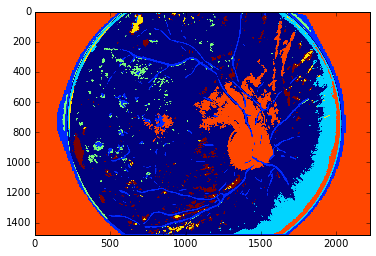

In [20]:
%matplotlib inline
out_file = path.join(output, path.splitext(path.split(im_file)[1])[0] + ".png")
im = cv2.imread(out_file, cv2.IMREAD_GRAYSCALE)
plt.imshow(im)
plt.show()

In [52]:
file_list = os.listdir(preprocessed)
file_list = map(lambda f: path.join(preprocessed, f), file_list)
file_list = filter(lambda f: path.isfile(f) and path.splitext(f)[1] == '.jpeg', file_list)
                      

In [23]:
len(file_list)

35126

In [ ]:
dv = Client()[:]
features = dv.map(extract_labels, np.array(file_list))
features.wait()
#df = pd.DataFrame(data = features[:])

#df.to_csv(path.join(output, "features.txt"), index = False, header = False)

In [53]:
orig_files = set(map(lambda f: path.splitext(path.split(f)[1])[0],file_list))
done_files = set(map(lambda f: path.splitext(f)[0], os.listdir(output)))
to_do = orig_files.difference(done_files)
file_list = map(lambda f: path.join(preprocessed, f + ".jpeg"), to_do)

In [57]:
len(file_list) + 29168

35126